In [2]:

import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from matplotlib.patches import Circle
from numpy.linalg import det, inv
from scipy.linalg import rq

In [3]:
# Code for Part 1 starts here

# Step 1: Load the data file pt_corres.mat
data_part1 = scipy.io.loadmat('pt_corres.mat')
cam_pts_3D = data_part1['cam_pts_3D']  # Load the 3d points
pts_2D = data_part1['pts_2D']  # Load the corresponding 2d points

print(pts_2D.shape)
print(cam_pts_3D.shape)

# Step 2: Write your code here to compute the camera intrinsics

#Obtain the transpose of two matrices
pts_2DT = np.transpose(pts_2D)
cam_pts_3DT = np.transpose(cam_pts_3D)

one = np.ones((28, 1))

#Matrix AT is composed of three columns with the first column being the x values of the image points,
#second column being the y values of the image points and the third column being zeros

A = np.hstack((pts_2DT, one))
AT = np.transpose(A)

#Compose matrix BT such that 1st column is X/Z, 2nd column is Y/Z, 3rd column is one
x1 = np.empty((28, 1))
x2 = np.empty((28, 1))
for i in range(0, 28):
    x1[i] = cam_pts_3DT[i][0] / cam_pts_3DT[i][2]
    x2[i] = cam_pts_3DT[i][1] / cam_pts_3DT[i][2]

B = np.hstack((x1, x2, one))
BT = np.transpose(B)
Binv = np.linalg.pinv(BT)
print("K", np.dot(AT, Binv))
# Code for Part 1 ends here

(2, 28)
(3, 28)
K [[ 3.38625072e+03  1.27159260e+01  8.52916937e+02]
 [ 1.85319235e+00  3.42886718e+03  6.27551184e+02]
 [-9.99200722e-16  1.22124533e-15  1.00000000e+00]]


P =  [[ 2.24468524e-01  2.82252106e-02 -4.46581005e-02  6.47418343e-01]
 [ 3.13049122e-03 -1.77345292e-01 -1.43567369e-01  6.89636308e-01]
 [-8.96065658e-07  2.74079257e-05 -5.24236468e-05  1.17447045e-03]]
K =  [[ 3.80781877e+03 -8.16178109e+00  8.32399977e+02]
 [ 0.00000000e+00  3.78129094e+03  7.60763925e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
R =  [[ 0.99974008  0.02211926 -0.00552403]
 [ 0.01704062 -0.88594483 -0.46347748]
 [-0.01514576  0.46326288 -0.88609148]]
t =  [-1.46772505 -0.91125501 19.85150442]
Reprojection Error 0.44131679518528966


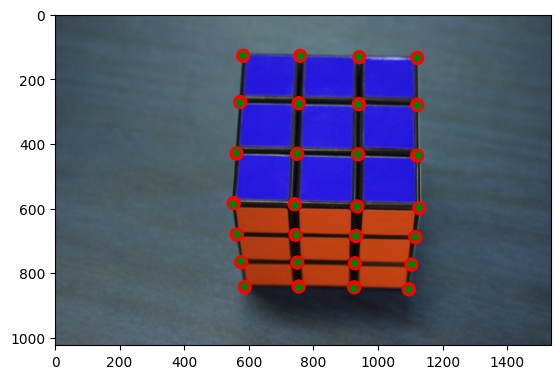

In [4]:

def calibrate(x, X):
    '''
    This function computes camera projection matrix from 3D scene points
    and corresponding 2D image points with the Direct Linear Transformation (DLT).

    Usage:
    P = calibrate(x, X)

    Input:
    x: 2xn image points
    X: 3xn scene points

    Output:
    P: 3x4 camera projection matrix

    '''

    # Your code goes here

    # Hint 1: Convert to homogeneous coordinates first
    # Hint 2: np.hstack and np.vstack are useful functions

    # Warning: The svd function from Numpy returns U, Sigma and V_transpose (not V, unlike Matlab)

    xt = np.transpose(x)
    Xt = np.transpose(X)
    #print Xt
    #print xt

    Xt = np.hstack((Xt, np.ones((28, 1))))
    print
    Xt.shape
    zero4 = np.array((0, 0, 0, 0))

    M = np.array((56, 12))
    for i in range(0, 28):
        A = np.hstack((zero4, -Xt[i], xt[i][1] * Xt[i]))
        B = np.hstack((Xt[i], zero4, -xt[i][0] * Xt[i]))
        A = np.reshape(A, (1, 12))
        B = np.reshape(B, (1, 12))
        if i == 0:
            M = np.vstack((A, B))

        else:
            M = np.vstack((M, A, B))

    u, s, vtranspose = np.linalg.svd(M)
    v = np.transpose(vtranspose)
    p = v[:, 11]

    P = p.reshape((3, 4))
    return P


#######################################################################################################################################################################################################

def P_to_KRt(P):
    '''

    This function computes the decomposition of the projection matrix into intrinsic parameters, K, and extrinsic parameters Q (the rotation matrix) and t (the translation vector)

    Usage:
    K, Q, t = P_to_KRt(P)

    Input:
    P: 3x4 projection matrix

    Outputs:
    K: 3x3 camera intrinsics
    Q: 3x3 rotation matrix (extrinsics)
    t: 3x1 translation vector(extrinsics)

    '''

    M = P[0:3, 0:3]

    R, Q = rq(M)

    K = R / float(R[2, 2])

    if K[0, 0] < 0:
        K[:, 0] = -1 * K[:, 0]
        Q[0, :] = -1 * Q[0, :]

    if K[1, 1] < 0:
        K[:, 1] = -1 * K[:, 1]
        Q[1, :] = -1 * Q[1, :]

    if det(Q) < 0:
        print
        'Warning: Determinant of the supposed rotation matrix is -1'

    P_3_3 = np.dot(K, Q)

    P_proper_scale = (P_3_3[0, 0] * P) / float(P[0, 0])

    t = np.dot(inv(K), P_proper_scale[:, 3])

    return K, Q, t


#######################################################################################################################################################################################################

# Code for Part 2 starts here

# Step 1 : Load the data files rubik_2D_pts.mat and rubik_3d_pts.mat

pts_3d = scipy.io.loadmat('rubik_3D_pts.mat')[
    'pts_3d']  # 3D points in the world-coordinate system with one of the corners of the Rubik's cube as the origin; side of each smaller cube = 1 unit
pts_2d = scipy.io.loadmat('rubik_2D_pts.mat')['pts_2d']  # The corresponding 2D points on the image rubik_cube.jpg

# Step 2: Get the camera calibration matrix P

P = calibrate(pts_2d, pts_3d)  # You need to fill in the code for this function before you execute this part of the code

print('P = ', P)

# Step 3: Use the function P_to_KRt (already written for you) to decompose P into intrinsics (K) and extrinsics (R and t)
[K, R, t] = P_to_KRt(P)

print('K = ', K)
print('R = ', R)
print('t = ', t)
Xt = np.transpose(pts_3d)
Xt = np.hstack((Xt, np.ones((28, 1))))
X_ = np.transpose(Xt)

# Write code here to compute the average reprojection error (averaged over the 28 points given)
xnew = np.dot(P, X_)
xnewt = np.transpose(xnew)
x1 = np.empty((28, 1))
x2 = np.empty((28, 1))
for i in range(0, 28):
    x1[i] = xnewt[i][0] / xnewt[i][2]
    x2[i] = xnewt[i][1] / xnewt[i][2]

x_proj = np.hstack((x1, x2))
xt = np.transpose(pts_2d)
sumerr = 0
for i in range(0, 28):
    sumerr += np.square(xt[i][0] - x_proj[i][0]) + np.square(xt[i][1] - x_proj[i][1])
reproj_err = np.sqrt(sumerr) / 28
print("Reprojection Error", reproj_err)

# Display the given 2D points and the reprojected 2D points on the Rubik's Cube image provided
fig, ax = plt.subplots(1)
ax.set_aspect('equal')
img = cv2.imread("rubik_cube.jpg")
xorg = xt[:, 0]
yorg = xt[:, 1]
xproj = x_proj[:, 0]
yproj = x_proj[:, 1]
for xx, yy in zip(xorg, yorg):
    circ = Circle((xx, yy), 20, color='r')
    ax.add_patch(circ)

for xx, yy in zip(xproj, yproj):
    circ = Circle((xx, yy), 10, color='g')
    ax.add_patch(circ)

ax.imshow(img)

# Code for Part 2 ends here